In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [ ]:
cd "/content/drive/MyDrive"

In [ ]:
cd "/content/drive/MyDrive/selection-of-criminals_with_syndata/CTGAN_syndata_generaton" 

In [ ]:
!pip install sdmetrics

## 2. Review generated data similarity(Heat map)

- 히트맵은 일반적으로 서로 다른 기능 간의 상관 관계와 같이 데이터 세트에서 둘 이상의 변수 간의 관계를 시각화하는 데 사용됩니다.
- 이를 통해 서로 다른 변수 간의 상관 관계가 높거나 낮은 영역과 같이 데이터의 패턴과 추세를 쉽게 시각화할 수 있습니다.
- 히트맵은 복잡한 데이터세트에서 중요한 통찰력과 관계를 빠르게 강조할 수 있으므로 데이터 분석 및 시각화에 자주 사용됩니다. 

- 히트맵 분석을 통해서 원본데이터와 합성데이터 각각의 서로 다른 변수의 상관 관계를 빠르게 확인 할 수 있습니다.
- 지난 작업 때 원본 데이터와 합성 데이터의 칼럼의 순서를 동일하게 정렬한 이유 입니다. 

### Load Libary

In [2]:
import pandas as pd
import copy
import time
import numpy as np

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt 

#matplotlib의 font_manager 객체를 통해 우리가 그릴 Heatmap의 폰트를 설정합니다.
import matplotlib.font_manager as fm

#구글 코랩에 기본으로 제공되는 DejaVu Sans라는 글꼴을 활용합니다. 
plt.rcParams['font.family'] = 'DejaVu Sans'

#font 설정을 위한 함수, 폰트가 설치되어있는 경로와 사이즈를 결정한다. 
def set_font():
    font_path = '/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/'
    fontprop = fm.FontProperties(fname=font_path, size=12)
    return fontprop

fontprop = set_font()

In [4]:
#Jupiter Cell Full Screen View
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# useful for debuging (print the results of both formulas and functions entered in one cell of Jupiter)
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
# Each column width at maximum (print all column contents)
pd.set_option('display.max_colwidth', -1)
# Show up to 500 rows
pd.set_option('display.max_rows', 500)
# Display up to 500 columns
pd.set_option('display.max_columns', 500)
# Total length of data frame
pd.set_option('display.width', 1000)

print('ready to run')
# logging starttime 
startTime = time.time()

ready to run


 ### Load Data

- 지정된 경로에서 원본 데이터와 합성데이터를 불러와서 copy를 실행합니다. 

In [5]:
df_syn_01 = pd.read_csv('./data_sample/df_syn_en_14.csv', encoding='utf-8-sig') #새로운 가상데이터

In [6]:
df_syn_base = pd.read_csv('df_syn_en.csv', encoding='utf-8-sig') #기존 가상데이터

In [7]:
copy_syn = copy.deepcopy(df_syn_01)

In [8]:
copy_base = copy.deepcopy(df_syn_base)

#### 데이터 확인

In [9]:
copy_syn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   dec_custom_code         1600 non-null   int64  
 1   imp_dec_code            1600 non-null   object 
 2   imp_trd_code            1600 non-null   int64  
 3   imp_typ_code            1600 non-null   int64  
 4   collect_code            1600 non-null   int64  
 5   typ_transport_code      1600 non-null   int64  
 6   dec_mark                1600 non-null   object 
 7   importer                1600 non-null   object 
 8   ovs_cust_code           1395 non-null   object 
 9   exps_carr_code          438 non-null    object 
 10  HS10                    1600 non-null   int64  
 11  country_ship_code       1600 non-null   object 
 12  country_orig_code       1600 non-null   object 
 13  trff_rate               1600 non-null   float64
 14  trff_class_code         1600 non-null   

In [10]:
copy_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54000 entries, 0 to 53999
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   dec_num                 54000 non-null  int64  
 1   dec_date                54000 non-null  object 
 2   dec_custom_code         54000 non-null  int64  
 3   imp_dec_code            54000 non-null  object 
 4   imp_trd_code            54000 non-null  int64  
 5   imp_typ_code            54000 non-null  int64  
 6   collect_code            54000 non-null  int64  
 7   typ_transport_code      54000 non-null  int64  
 8   dec_mark                54000 non-null  object 
 9   importer                54000 non-null  object 
 10  ovs_cust_code           48799 non-null  object 
 11  exps_carr_code          9538 non-null   object 
 12  HS10                    54000 non-null  int64  
 13  country_ship_code       54000 non-null  object 
 14  country_orig_code       54000 non-null

- 원본 데이터 복사본의 'dec_num'과 'dec_date'는 적절한 상관도 비교를 위해 삭제 

In [11]:
copy_base = copy_base.drop(['dec_num','dec_date'],axis = 1)

- 삭제가 되었는 지 확인합니다. 

In [12]:
copy_base.shape

(54000, 20)

### Labeling base Data (Heatmap 1)

- Label encoding (change category data to numeric)
- Find the correlation between the numeric transformed data

In [13]:
encoder = LabelEncoder()

for column_name,item in copy_base.iteritems(): 
    encoder.fit(item)
    labels = encoder.transform(item)
    copy_base[column_name] = labels

- 'imp_dec_code' 칼럼은 편향된 데이터로 적은 양의 샘플링을 할때 적합한 결과를 얻을 수 없기 때문에 제거합니다. 

In [14]:
copy_base = copy_base.drop('imp_dec_code',axis=1)

In [21]:
corr = copy_base.corr()

### Labeling generated synthetic data (Heatmap 2)

- Label encoding (change category data to numeric)
- Find the correlation between the numeric transformed data

In [16]:
encoder = LabelEncoder()

for column_name,item in copy_syn.iteritems(): #데이터프레임의 데이터를 숫자형으로 인코딩함
    encoder.fit(item)
    labels = encoder.transform(item)
    copy_syn[column_name] = labels

- 'imp_dec_code' 칼럼은 편향된 데이터로 적은 양의 샘플링을 할때 적합한 결과를 얻을 수 없기 때문에 제거합니다. 

In [17]:
copy_syn = copy_syn.drop('imp_dec_code',axis=1)

In [22]:
corr2 = copy_syn.corr()

### Create and compare heat maps

- 두가지 히트맵을 시각적으로 비교할 수 있습니다. (첫번째 히트맵: 원본데이터 활용, 두번째 히트맵: 합성데이터 활용)
- 히트맵은 상관도 절댓값이 높은 경우가 상관관계가 크다고 할 수 있습니다. 
- 두가지 히트맵의 짙은 사각형이 유사한 위치에 나타난 것을 확인할 수 있습니다. 
- 시각적으로 합성데이터와 원본 데이터의 유사성에 대해서 확인할 수 있습니다.

<AxesSubplot: >

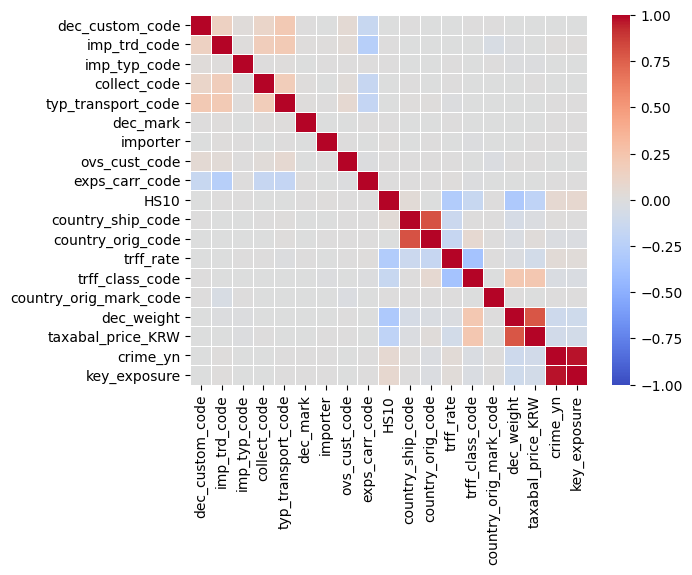

In [23]:
sns.heatmap(corr, cmap='coolwarm', linewidths =0.5, annot_kws={'size':10, 'fontproperties':fontprop}, vmin=-1.0)

<AxesSubplot: >

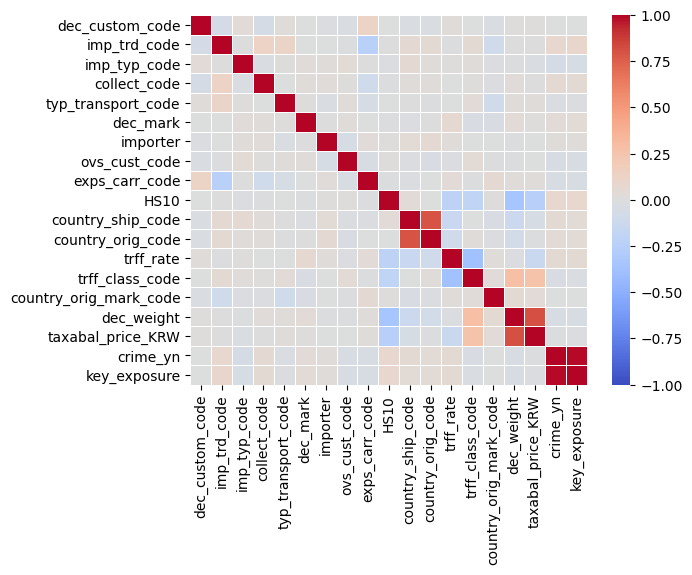

In [24]:
sns.heatmap(corr2, cmap='coolwarm', linewidths =0.5, annot_kws={'size':10, 'fontproperties':fontprop},vmin=-1.0)